In [84]:
# Usei como base esse tutorial:
# https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/pt-br/tutorials/keras/regression.ipynb#scrollTo=f-OHX4DiXd8x

In [85]:
# # Clear logs
# %rm -rf ./logs/

# Ativação do Tensorboard
%conda activate pystock
%load_ext tensorboard

# Reload Tensorboar
# %reload_ext tensorboard



Note: you may need to restart the kernel to use updated packages.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Sequential model

*Dense model 16*
*Dense model 16*
*Dense model 8*
*Dense model 4*
*Epoch 350*

_MSE: 1.31_
epoch: 350

Activation: softplus
Optimizer: Adam

15/15 - 0s - loss: 0.6325 - mae: 0.5830 - mse: 0.6325
Testing set Mean Abs Error:  0.58 ibova_0

In [86]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import datetime

from tensorflow import keras
from tensorflow.keras import layers

# Lendo Dfs

In [87]:
PATH_TREINO = '../Data/3_Gold/Treino_all_stocks.csv'
DF_TREINO = pd.read_csv(PATH_TREINO, sep=",")

PATH_VALIDACAO = '../Data/3_Gold/Validacao_all_stocks.csv'
DF_VALIDACAO = pd.read_csv(PATH_VALIDACAO, sep=",")

PATH_TESTE = '../Data/3_Gold/Teste_all_stocks.csv'
DF_TESTE = pd.read_csv(PATH_TESTE, sep=",")

In [88]:
# index,
# ibova_0,ibova_1,ibova_2,ibova_3,ibova_4,ibova_5,
# oil_0,oil_1,oil_2,oil_3,oil_4,oil_5,usd_0,
# usd_1,usd_2,usd_3,usd_4,usd_5,
# abev_0,abev_1,abev_2,abev_3,abev_4,abev_5,
# jbs_0,jbs_1,jbs_2,jbs_3,jbs_4,jbs_5,
# petr_0,petr_1,petr_2,petr_3,petr_4,petr_5,
# vale_0,vale_1,vale_2,vale_3,vale_4,vale_5

In [89]:
train_dataset = DF_TREINO
train_dataset = train_dataset.drop(['oil_0','usd_0','abev_0','jbs_0','petr_0','vale_0',], axis=1)
train_labels = train_dataset.pop('ibova_0')

test_dataset = DF_TESTE
test_dataset = test_dataset.drop(['oil_0','usd_0','abev_0','jbs_0','petr_0','vale_0',],axis=1)
test_labels = test_dataset.pop('ibova_0')

valid_dataset = DF_VALIDACAO
valid_dataset = valid_dataset.drop(['ibova_0','oil_0','usd_0','abev_0','jbs_0','petr_0','vale_0',],axis=1)
# valid_labels = valid_dataset.pop('ibova_0')

# Inspecionando os dados

In [90]:
# sns.pairplot(train_dataset[['index','ibova_0','ibova_1','ibova_2','ibova_3','ibova_4','oil_0','oil_1','oil_2','oil_3','oil_4','usd_0','usd_1','usd_2','usd_3','usd_4']], diag_kind="kde")
# sns.pairplot(train_dataset[['index','ibova_0','oil_0','usd_0']], diag_kind="kde")
# sns.pairplot(train_dataset[['ibova_1','oil_1','usd_1']], diag_kind="kde")

In [91]:
train_stats = train_dataset.describe()
# train_stats

# Definindo o modelo

In [92]:
# Diminuir quantidade de nós 
# Funcao logistica pra optimization
# Ver se relu funciona com RMSprop

# softplus melhor até agora
def build_model():
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(8, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='linear')
  ])

  # optimizer = tf.keras.optimizers.RMSprop(0.001)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,
                                       beta_1=0.9,
                                       beta_2=0.999,
                                       amsgrad=True)
  
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()

# rmse pra avaliação, nao para loss


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 16)                592       
_________________________________________________________________
dense_36 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_37 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 5         
Total params: 841
Trainable params: 841
Non-trainable params: 0
_________________________________________________________________


# Definindo Métricas

In [93]:
# Seguindo esse tutorial para extrair metricas para o tensorboard
# https://www.tensorflow.org/tensorboard/get_started?hl=pt


# Define metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')


# Para salvar os arquivos de log
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)



## Testando o modelo

In [94]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
# example_result

# Treinado o modelo

In [95]:
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


EPOCHS = 300 

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_mse', patience=25, mode='min' ,restore_best_weights=True)

# earlystop como o val_mse 
# Add dados de validação 
#  validation_data=
# train_dataset = x
# train_labels = y

history = model.fit(
  train_dataset,train_labels,
  # validation_data=valid_dataset,
  validation_split=0.2,
  epochs=EPOCHS, verbose=1,
  callbacks=([early_stop,tensorboard_callback]))

#   validation_data=valid_dataset,

Epoch 1/300
36/36 [==============================] - 3s 77ms/step - loss: 242.1542 - mae: 13.4625 - mse: 242.1542 - val_loss: 793.6509 - val_mae: 28.1071 - val_mse: 793.6509
Epoch 2/300
36/36 [==============================] - 0s 2ms/step - loss: 187.3017 - mae: 11.8431 - mse: 187.3017 - val_loss: 616.7352 - val_mae: 24.7756 - val_mse: 616.7352
Epoch 3/300
36/36 [==============================] - 0s 2ms/step - loss: 146.2697 - mae: 10.4600 - mse: 146.2697 - val_loss: 482.9848 - val_mae: 21.9235 - val_mse: 482.9848
Epoch 4/300
36/36 [==============================] - 0s 2ms/step - loss: 115.2935 - mae: 9.2871 - mse: 115.2935 - val_loss: 382.6595 - val_mae: 19.5125 - val_mse: 382.6595
Epoch 5/300
36/36 [==============================] - 0s 3ms/step - loss: 91.7637 - mae: 8.2850 - mse: 91.7637 - val_loss: 306.2531 - val_mae: 17.4543 - val_mse: 306.2531
Epoch 6/300
36/36 [==============================] - 0s 2ms/step - loss: 73.7521 - mae: 7.4218 - mse: 73.7521 - val_loss: 246.3313 - val_m

In [96]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
295,0.128524,0.263654,0.128524,0.127351,0.270066,0.127351,295
296,0.128441,0.263894,0.128441,0.130698,0.277904,0.130698,296
297,0.128133,0.262718,0.128133,0.127449,0.270227,0.127449,297
298,0.128173,0.263426,0.128173,0.144093,0.297200,0.144093,298
299,0.128444,0.263025,0.128444,0.132241,0.277216,0.132241,299


In [97]:
hist.mse.min()

0.12798623740673065

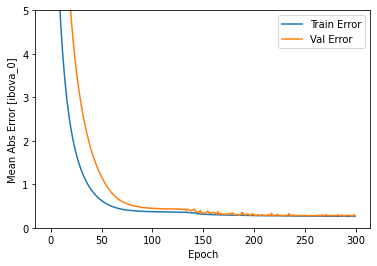

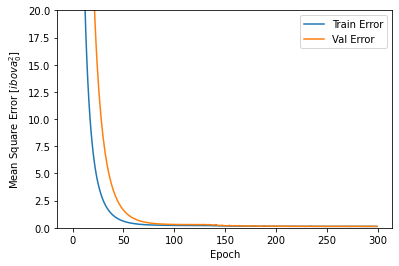

In [98]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ibova_0]')
  plt.plot(hist['epoch'], hist['mae'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ibova_0^2$]')
  plt.plot(hist['epoch'], hist['mse'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Epoch 1/300
36/36 [==============================] - 1s 25ms/step - loss: 0.5500 - mae: 0.5864 - mse: 0.5500 - val_loss: 1.0923 - val_mae: 0.8076 - val_mse: 1.0923
Epoch 2/300
36/36 [==============================] - 0s 2ms/step - loss: 0.4685 - mae: 0.5418 - mse: 0.4685 - val_loss: 0.9332 - val_mae: 0.7445 - val_mse: 0.9332
Epoch 3/300
36/36 [==============================] - 0s 2ms/step - loss: 0.4184 - mae: 0.5130 - mse: 0.4184 - val_loss: 0.7115 - val_mae: 0.6514 - val_mse: 0.7115
Epoch 4/300
36/36 [==============================] - 0s 2ms/step - loss: 0.3820 - mae: 0.4907 - mse: 0.3820 - val_loss: 0.6352 - val_mae: 0.6181 - val_mse: 0.6352
Epoch 5/300
36/36 [==============================] - 0s 2ms/step - loss: 0.3523 - mae: 0.4672 - mse: 0.3523 - val_loss: 0.5576 - val_mae: 0.5841 - val_mse: 0.5576
Epoch 6/300
36/36 [==============================] - ETA: 0s - loss: 0.2321 - mae: 0.3999 - mse: 0.232 - 0s 2ms/step - loss: 0.3282 - mae: 0.4554 - mse: 0.3282 - val_loss: 0.5098 - val

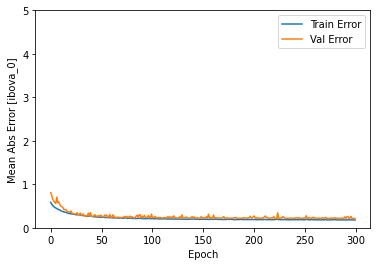

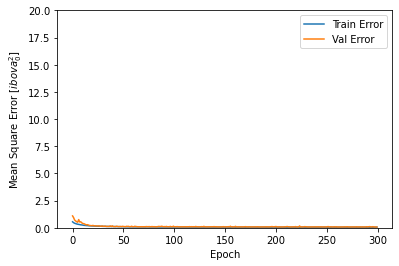

In [99]:
model = build_model()

# O parâmetro patience é o quantidade de epochs para checar as melhoras
early_stop = keras.callbacks.EarlyStopping(
  monitor='val_mse', patience=50, mode='min' ,restore_best_weights=True)

history = model.fit(train_dataset, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=1, callbacks=[early_stop, tensorboard_callback])

# Mudar os dados de validação

plot_history(history)

In [100]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print(f"Testing set Mean Abs Error: {mse:5.2f} ibova_0")

15/15 - 0s - loss: 0.1866 - mae: 0.2279 - mse: 0.1866
Testing set Mean Abs Error:  0.19 ibova_0


# Realizando as previsões

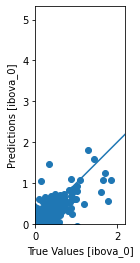

In [101]:
test_predictions = model.predict(test_dataset).flatten()
plt.figure(figsize=(24,4))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [ibova_0]')
plt.ylabel('Predictions [ibova_0]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

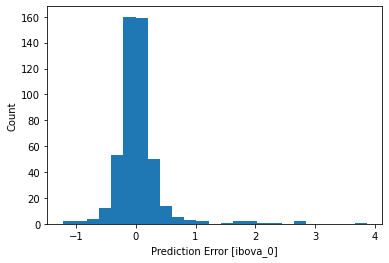

In [102]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [ibova_0]")
_ = plt.ylabel("Count")

In [103]:
# Imprimindo valores reais
ibova_test = raw_dataset.ibova_0[:479]
plt.plot(ibova_test, color ='r', label='ibova_REAL')
plt.xlabel("Dates")
plt.ylabel("Variation ROC")
plt.title("ibova_REAL")
plt.legend()

NameError: name 'raw_dataset' is not defined

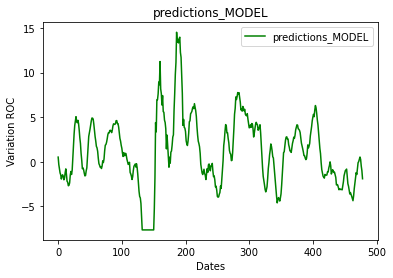

In [ ]:
# Imprimindo previsoes
plt.plot(test_predictions, color ='g', label='predictions_MODEL')
plt.xlabel("Dates")
plt.ylabel("Variation ROC")
plt.title("predictions_MODEL")
plt.legend()


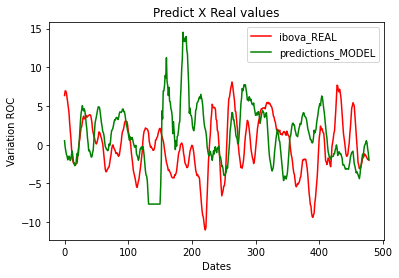

In [ ]:
# Predictt X Real values
plt.plot(ibova_test, color ='r', label='ibova_REAL')
plt.plot(test_predictions, color ='g', label='predictions_MODEL')
plt.xlabel("Dates")
plt.ylabel("Variation ROC")
plt.title("Predict X Real values")
plt.legend()
plt.show()

In [ ]:
# Analisando Medias:

print(f'Massa de predição: {test_predictions.mean()}')
print(f'Massa inicial: {ibova_test.mean()}')
print(f'Diferenças das médias: {ibova_test.mean() - test_predictions.mean()}')

Massa de predição: 1.1128727197647095
Massa inicial: -0.1473508431278343
Diferenças das médias: -1.2602235628925438


In [ ]:
# test_dataset